In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def show(figsize, cols, *images):
    rows = len(images) // cols + 1
    plt.figure(figsize=figsize)
    for idx, (title, img) in enumerate(images):
        plt.subplot(int(f"{rows}{cols}{idx + 1}"))
        plt.axis("off")
        plt.imshow(img)
        plt.title(f"No.{idx + 1} {title}")

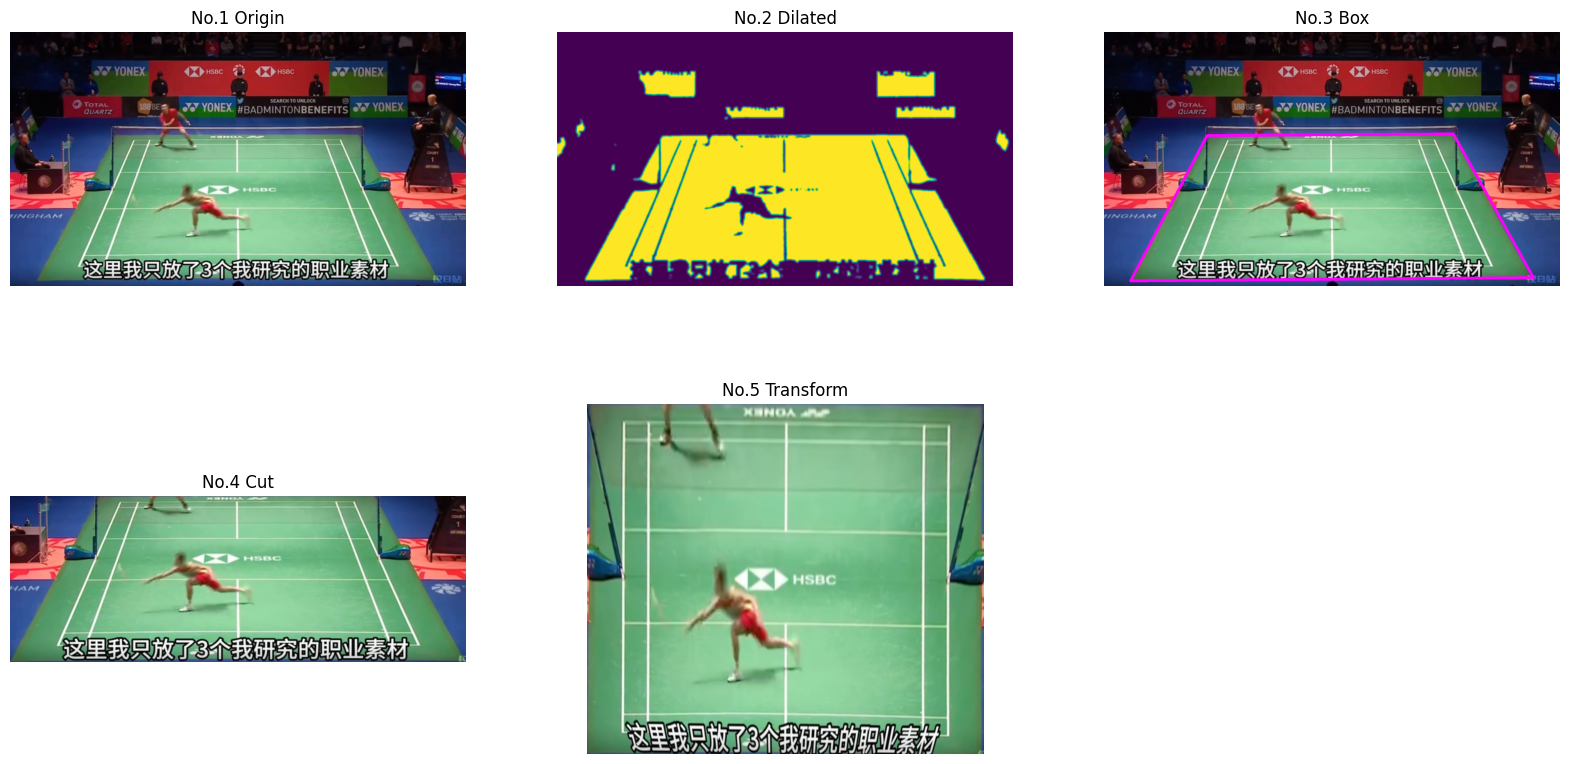

In [48]:

img = cv2.imread("images/001.png")

green = [
    np.array([40, 40, 40]),
    np.array([80, 255, 255])
]

def pre_process(img, color):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower, upper = color
    mask = cv2.inRange(hsv, lower, upper)
    blurred = cv2.GaussianBlur(mask, (15, 15), 0)
    dilated = cv2.dilate(blurred, None, iterations=1)
    return dilated

def order_points(box):
    # Initialize a list of coordinates that will be ordered
    sbox = box.reshape(4, 2)
    ret = np.zeros((4, 2), dtype=np.int32)
    s = sbox.sum(axis=1)
    ret[0] = sbox[np.argmin(s)]
    ret[2] = sbox[np.argmax(s)]

    diff = np.diff(sbox, axis=1)
    ret[1] = sbox[np.argmin(diff)]
    ret[3] = sbox[np.argmax(diff)]
    return ret

def find_court(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If our approximated contour has four points, we can assume it's the box
        if len(approx) == 4:
            return order_points(approx)

def draw_box(img, box):
    ret = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
    cv2.drawContours(ret, [box], 0, (255, 0, 255), 10)
    return ret

def cut(img, box):
    ret = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (x, y, w, h) = cv2.boundingRect(box)
    return ret[y:y+h, x:x+w]

def transform(img, box):
    ret = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (top_left, top_right, bottom_left, bottom_right) = box
    width_bottom = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    width_top = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    width = max(int(width_bottom), int(width_top))
    
    height_right = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    height_left = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
    height = max(int(height_right), int(height_left))

    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

    matrix = cv2.getPerspectiveTransform(box.astype(np.float32), dst)
    return cv2.warpPerspective(ret, matrix, (width, height)).astype(np.uint8)

dilated = pre_process(img, green)
court = find_court(dilated)

if court is not None:
    show(
        (20, 10), 3,
        ["Origin", cv2.cvtColor(img, cv2.COLOR_BGR2RGB)],
        ["Dilated", dilated],
        ["Box", draw_box(img, court)],
        ["Cut", cut(img, court)],
        ["Transform", transform(img, court)]
    )

In [288]:
import cv2
import numpy as np

def process_image(image_path, contour, output_path):
    # Read the image
    img = cv2.imread(image_path)

    # Ensure the contour has 4 points
    if len(contour) != 4:
        raise ValueError("Contour must have exactly 4 points")

    # Order the points in the contour
    rect = order_points(np.array(contour))

    # Get width and height of the new image
    width = max(np.linalg.norm(rect[0] - rect[1]), np.linalg.norm(rect[2] - rect[3]))
    height = max(np.linalg.norm(rect[0] - rect[3]), np.linalg.norm(rect[1] - rect[2]))

    # Define destination points for perspective transform
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Calculate the perspective transform matrix
    print("shape", rect.shape, dst.shape)
    print("dtype", rect.dtype, dst.dtype)
    M = cv2.getPerspectiveTransform(rect, dst)

    # Perform the perspective transform
    warped = cv2.warpPerspective(img, M, (int(width), int(height)))

    # Save the result
    cv2.imwrite(output_path, warped)

def order_points(pts):
    # Initialize a list of coordinates that will be ordered
    rect = np.zeros((4, 2), dtype="float32")

    # The top-left point will have the smallest sum
    # The bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Compute the difference between the points
    # The top-right point will have the smallest difference
    # The bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

# Example usage
image_path = "images/001.png"
contour = [
    (0, 100),  # Top-left
    (250, 10),   # Top-right
    (450, 300),  # Bottom-right
    (50, 250)    # Bottom-left
]
output_path = "0.png"

process_image(image_path, contour, output_path)

shape (4, 2) (4, 2)
dtype float32 float32
